# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/Thesis/
# %cd Mydrive/

%cd drive/MyDrive/Colab\ Notebooks/Thesis_st121166
# !ls

/content/drive/MyDrive/Colab Notebooks/Thesis_st121166


In [ ]:
# Install libraries
!pip install mne
!pip install PyWavelets
# !pip install pyriemann

     |████████████████████████████████| 7.4 MB 3.6 MB/s 


# Reference paper

- Wavelet ICA (wICA)
    - https://ieeexplore.ieee.org/document/6843355

- Reference for the data
    - https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

# Import Libraries and Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt
import scipy
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize

In [ ]:
number_subjects = 54

initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
number_electrode = len(EEG_electrodes)

initial_pure_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("Datasets/semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("Datasets/semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

def grab_children(father):
    nestedDict_to_lists = []
    for key, value in father.items():
        if type(value) == dict:
            nestedDict_to_lists.append(grab_children(value))
        else:
            nestedDict_to_lists.append(value)
    return nestedDict_to_lists

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

## EDA

In [ ]:
# Extract only EEG signals
extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)
extracted_HEOG = ExtractOnlyEEG(initial_HEOG)
extracted_VEOG = ExtractOnlyEEG(initial_VEOG)

# Find minimum signal's length
minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

# Resample
selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_HEOG = SelectLengthChannel(dict_inputEEG=extracted_HEOG,
                                              selectEEGLength=selectedEEGLength)
selectedLength_VEOG = SelectLengthChannel(dict_inputEEG=extracted_VEOG,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Minumum EEG length: 5401
Selected EEG length: 5200
Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


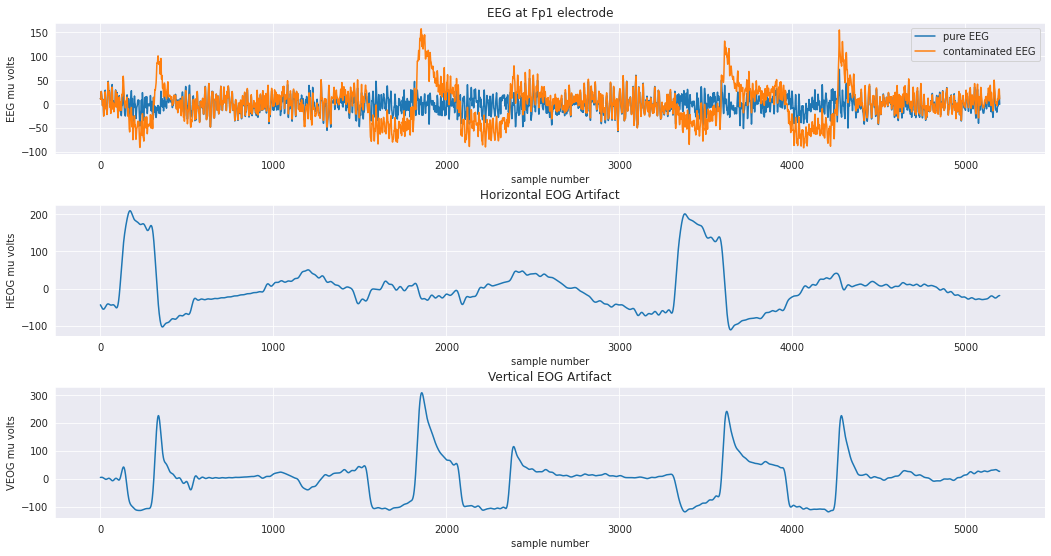

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(selectedLength_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(selectedLength_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

# ICA process

## Functions

In [ ]:
def df_to_raw(df):
    sfreq = 200 # According to frequency sampling of data

    ch_names = list(df.columns)
    ch_types = ['eeg'] * len(df.columns) 
    
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
#     df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw



def EEG_to_ICs_withICA(raw_object):    
    #  3.1 Notch Filter
    # # data's frequency sampling / 2 based on Nyquist Theorem
    # raw_object.notch_filter(np.arange(50, sfreq/2, 50), filter_length='auto', phase='zero') 
    # raw_object.plot_psd()

    # 3.2 Band pass Filter
    # #Filter code looks like this
    # raw_object.filter(4,50, method='iir')
    # raw_object.plot_psd()

    filt_raw = raw_object.copy()
    filt_raw.load_data().filter(l_freq=1., h_freq=None)

    # set up and fit the ICA
    # Extended Infomax
    ica = ICA(n_components=int(n_EEG_electrodes), method="infomax", fit_params=dict(extended=True), random_state=32)
    ica.fit(filt_raw)
    ica.plot_sources(filt_raw)
    ICs = ica.get_sources(filt_raw)
    return filt_raw, ICs, ica

In [ ]:
def compute_kurtosis(data):
    
    """Kurtosis of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **kurtosis**
    """
    
    ndim = data.ndim
    return scipy.stats.kurtosis(data, axis=ndim - 1, fisher=False)
#     return scipy.stats.kurtosis(data)

def compute_kurtosis(data):
    
    """Kurtosis of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **kurtosis**
    """
    
    ndim = data.ndim
    return scipy.stats.kurtosis(data, axis=ndim - 1, fisher=False)
#     return scipy.stats.kurtosis(data)

def _app_samp_entropy_helper(data, emb, metric='chebyshev',
                             approximate=True):
    """Utility function for `compute_app_entropy`` and `compute_samp_entropy`.
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    approximate : bool (default: True)
        If True, the returned values will be used to compute the
        Approximate Entropy (AppEn). Otherwise, the values are used to compute
        the Sample Entropy (SampEn).
    Returns
    -------
    output : ndarray, shape (n_channels, 2)
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    n_channels, n_times = data.shape
    phi = np.empty((n_channels, 2))
    for j in range(n_channels):
        r = 0.2 * np.std(data[j, :], axis=-1, ddof=1)
        # compute phi(emb, r)
        _emb_data1 = _embed(data[j, None], emb, 1)[0, :, :]
        if approximate:
            emb_data1 = _emb_data1
        else:
            emb_data1 = _emb_data1[:-1, :]
        count1 = KDTree(emb_data1, metric=metric).query_radius(
            emb_data1, r, count_only=True).astype(np.float64)
        # compute phi(emb + 1, r)
        emb_data2 = _embed(data[j, None], emb + 1, 1)[0, :, :]
        count2 = KDTree(emb_data2, metric=metric).query_radius(
            emb_data2, r, count_only=True).astype(np.float64)
        if approximate:
            phi[j, 0] = np.mean(np.log(count1 / emb_data1.shape[0]))
            phi[j, 1] = np.mean(np.log(count2 / emb_data2.shape[0]))
        else:
            phi[j, 0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
            phi[j, 1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


def compute_app_entropy(data, emb=2, metric='chebyshev'):
    """Approximate Entropy (AppEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with
        :class:`~sklearn.neighbors.KDTree`. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **app_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=True)
    return np.subtract(phi[:, 0], phi[:, 1])


def compute_samp_entropy(data, emb=2, metric='chebyshev'):
    
    """Sample Entropy (SampEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: `KDTree.valid_metrics`.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **samp_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=False)
    if np.allclose(phi[:, 0], 0) or np.allclose(phi[:, 1], 0):
        raise ValueError('Sample Entropy is not defined.')
    else:
        return -np.log(np.divide(phi[:, 1], phi[:, 0]))
    
def _embed(x, d, tau):
    """Time-delay embedding.
    Parameters
    ----------
    x : ndarray, shape (n_channels, n_times)
    d : int
        Embedding dimension.
        The embedding dimension ``d`` should be greater than 2.
    tau : int
        Delay.
        The delay parameter ``tau`` should be less or equal than
        ``floor((n_times - 1) / (d - 1))``.
    Returns
    -------
    output : ndarray, shape (n_channels, n_times - (d - 1) * tau, d)
    """
    tau_max = np.floor((x.shape[1] - 1) / (d - 1))
    if tau > tau_max:
        warn('The given value (%s) for the parameter `tau` exceeds '
             '`tau_max = floor((n_times - 1) / (d - 1))`. Using `tau_max` '
             'instead.' % tau)
        _tau = tau_max
    else:
        _tau = int(tau)
    x = x.copy()
    X = np.lib.stride_tricks.as_strided(
        x, (x.shape[0], x.shape[1] - d * _tau + _tau, d),
        (x.strides[-2], x.strides[-1], x.strides[-1] * _tau))
    return X

In [ ]:
# Method for finding threshold, 'Thresholding selection rule'
def sqtwolog_threshold(wavelet_coeffs):
    """
    Universal thresholding
    """
    denom = scipy.stats.norm.ppf(0.75) # the constant value for Gaussian noise (0.6745)
    var = np.median(np.abs(wavelet_coeffs)) / denom
    N = len(wavelet_coeffs)
    thre = np.sqrt(var) * np.sqrt(2 * np.log(N))
    return thre

def rigsure_threshold(wavelet_coeffs):
    var = np.std(wavelet_coeffs)
    N = len(wavelet_coeffs)
    sqr_coeffs = []
    for coeff in wavelet_coeffs:
        sqr_coeffs.append(np.power(coeff, 2))
    sqr_coeffs.sort()
    pos = 0
    r = 0
    for idx, sqr_coeff in enumerate(sqr_coeffs):
        new_r = (N - 2 * (idx + 1) + (N - (idx + 1))*sqr_coeff + sum(sqr_coeffs[0:idx+1])) / N
        if r == 0 or r > new_r:
            r = new_r
            pos = idx
    thre = np.sqrt(var) * np.sqrt(sqr_coeffs[pos])
    return thre

def heursure_threshold(wavelet_coeffs):
    N = len(wavelet_coeffs)
    s = 0
    for coeff in wavelet_coeffs:
        s += np.power(coeff, 2)
    theta = (s - N) / N
    # It is divide by ...
    miu = np.power(np.log2(N), 3/2) / np.power(N, 1/2)
    if theta < miu:
        return sqtwolog_threshold(wavelet_coeffs)
    else:
        return min(sqtwolog_threshold(wavelet_coeffs), rigsure_threshold(wavelet_coeffs))
    
def statistical_threshold(wavelet_coeffs):
    """
    Put wavelet coefficients of one level to the function
    Return the statistical threshold value of that level
    """
    threshold_value = 1.5 * np.std(wavelet_coeffs)
    return threshold_value

In [ ]:
def denoised_with_DiscreteWavelet(oneCH_EEG, 
                                  motherWavelet="bior3.9", decLevel=8, 
                                  thresholdSelectionRule="statistical_threshold", thresholdingFunction="hard",
                                  lcoeffLevel=1, rcoeffLevel=5):
    """
    contEEG is a dataset containing contaminated EEG (54 subjects each has 19 EEG channels)
    motherWavelet = 'bior3.9' (Paper)
    decLevel = 8 (Calculate)
    thresholdSelectionRule = "heursure_threshold" or "statistical_threshold"
    thresholdingFunction = "soft" or "hard" thresholding
    lcoeffLevel = the coefficients corresponding to lower frequency bands that we want to threshold/denoise
    rcoeffLevel = the coefficients corresponding to upper frequency bands that we want to threshold/denoise
    """
    
    denoised_coeffs = [] # Prepare for contain denoise coefficients
    coeffs = pywt.wavedec(oneCH_EEG, wavelet=motherWavelet, level=decLevel)
    for ix, coeff in enumerate(coeffs):
        # thresholding has been done over the cD from level 8 up to level 3 (Cover OAs freq. band/related coefficients)
        threshold_value = None
        if ix in range(lcoeffLevel,rcoeffLevel):
            if thresholdSelectionRule == "statistical_threshold":
                threshold_value = statistical_threshold(wavelet_coeffs=coeff)
            else:
                threshold_value = heursure_threshold(wavelet_coeffs=coeff)

            # According to the paper
            # wavelet coefficient (wc) is removed if np.abs(wc) > threshold value
            denoised_coeff = np.where(np.abs(coeff) > threshold_value, 0, coeff)
            denoised_coeffs.append(denoised_coeff)

        else:
            denoised_coeffs.append(coeff)  
        
    denoised_oneCH_EEG = pywt.waverec(denoised_coeffs, wavelet=motherWavelet)
    return denoised_oneCH_EEG

## Process

In [ ]:
list_selected_cont_EEG_subjects = []
list_raws = []
np_raws = []
list_cont_ICs = []
list_denoised_EEG_subjects = []
list_ICA_model = []

for n_selecting_subject in range(number_subjects):
    
    ## Creating raw object
    selected_pure_EEG= selectedLength_pureEEG[list(selectedLength_pureEEG.keys())[n_selecting_subject]]
    selected_cont_EEG= selectedLength_contEEG[list(selectedLength_contEEG.keys())[n_selecting_subject]]
    selected_HEOG = selectedLength_HEOG[list(selectedLength_HEOG.keys())[n_selecting_subject]]
    selected_VEOG = selectedLength_VEOG[list(selectedLength_VEOG.keys())[n_selecting_subject]]

    # # 1st Version (Having EOG signals)
    # data_EEG = np.vstack((selected_cont_EEG, 
    #                       selected_HEOG, 
    #                       selected_VEOG)).transpose()

    # column_values_for_df_EEG = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 
    #                            'C4', 'P3', 'P4', 'O1', 'O2', 
    #                            'F7', 'F8', 'T3', 'T4', 'T5', 
    #                            'T6', 'Fz', 'Cz', 'Pz','HEOG', 'VEOG']

    # 2nd Version (No EOG signals)
    data_EEG = selected_cont_EEG.copy().transpose()

    column_values_for_df_EEG = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 
                               'C4', 'P3', 'P4', 'O1', 'O2', 
                               'F7', 'F8', 'T3', 'T4', 'T5', 
                               'T6', 'Fz', 'Cz', 'Pz']


    df_EEG = pd.DataFrame(data=data_EEG,
                          columns=column_values_for_df_EEG)
    
    # Each dataset has 19 EEG electrodes and around 5601 samples (30s duration * 200 frequency sampling)
    sfreq = 200
    n_samples = df_EEG.shape[0]

    # # 1st Version (Having EOG signals)
    # n_EOG_electrodes = 2
    # n_EEG_electrodes = df_EEG.shape[1] - n_EOG_electrodes

    # 2nd Version (No EOG signals)
    n_EOG_electrodes = 0
    n_EEG_electrodes = df_EEG.shape[1] - n_EOG_electrodes
    
    raw = df_to_raw(df_EEG)

    # get ICs from EEG signals
    result_fromICA = EEG_to_ICs_withICA(raw_object=raw)
    list_raws.append(result_fromICA[0])
    np_raws.append(result_fromICA[0].get_data())
    list_cont_ICs.append(result_fromICA[1].get_data())
    list_ICA_model.append(result_fromICA[2])
    
# Change list to Numpy
np_raws = np.array(np_raws)
np_cont_ICs = np.array(list_cont_ICs)


In [ ]:
np_norm_cont_ICs = []
for e_subj in np_cont_ICs:
    norm_cont_ICs = scipy.signal.normalize(b=e_subj, a=np.max(e_subj))[0]
    np_norm_cont_ICs.append(norm_cont_ICs)
np_norm_cont_ICs = np.array(np_norm_cont_ICs)                                       

In [ ]:
# Calculate mMSE
mMSE_ICs_subjects = []
for e_electrode in np_norm_cont_ICs:

    list_coarse_graining_electrodes = []
    
    for IC_value in e_electrode:
        
        list_coarse_graining_values = []
        length_data = IC_value.shape[-1]
        mMSE_scale_factor = 20
        range_coarse_graining = np.arange(1, int(length_data/mMSE_scale_factor)+1, 1)

        for j in range_coarse_graining:
            # Python is zero-index
            start_point = ((j-1)*mMSE_scale_factor)
            end_point = j * mMSE_scale_factor
            coase_graining_value = (1/mMSE_scale_factor) * np.sum(IC_value[start_point:end_point])
            list_coarse_graining_values.append(coase_graining_value)
            
        list_coarse_graining_electrodes.append(np.array(list_coarse_graining_values))
        
    mMSE_values = compute_samp_entropy(data=np.array(list_coarse_graining_electrodes))
    mMSE_ICs_subjects.append(mMSE_values)

mMSE_ICs_subjects = np.array(mMSE_ICs_subjects)
print(mMSE_ICs_subjects.shape)

(54, 19)


In [ ]:
# Calculate Kurtosis
Kurtosis_ICs_subjects = []
for e_electrode in np_norm_cont_ICs:
    Kurtosis_ICs_electrodes = []
    
    for IC_value in e_electrode:
        Kurtosis_value = compute_kurtosis(data=IC_value)
        Kurtosis_ICs_electrodes.append(Kurtosis_value)
    Kurtosis_ICs_subjects.append(np.array(Kurtosis_ICs_electrodes))

Kurtosis_ICs_subjects = np.array(Kurtosis_ICs_subjects)
print(Kurtosis_ICs_subjects.shape)

(54, 19)


In [ ]:
list_artifactual_ICs_subjects = []
list_non_artifactual_ICs_subjects = []
dict_ICs_subjects = {}

for n_selecting_subject in range(number_subjects):
    # alpha level of two tailed t-test = 0.05
    alpha = 0.05
    critical_value = scipy.stats.t.ppf(q=1-alpha/2,df=int(n_EEG_electrodes)-1)
    
    mMSE_ICs = mMSE_ICs_subjects[n_selecting_subject]
    kurtosis_ICs = Kurtosis_ICs_subjects[n_selecting_subject]
    
    lower_limit= np.mean(mMSE_ICs) - ((np.std(mMSE_ICs) / np.sqrt(len(mMSE_ICs)) * critical_value))
    upper_limit= np.mean(kurtosis_ICs) - ((np.std(kurtosis_ICs) / np.sqrt(len(kurtosis_ICs))) * critical_value)
    
    # print(f"Check which IC is artifact IC\n {(mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)}")
    artifact_ICs_indexs = (mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)
    non_artifact_ICs_indexs = np.invert(artifact_ICs_indexs)
    dict_ICs_subjects[n_selecting_subject] = artifact_ICs_indexs
    
#     print(np_norm_cont_ICs.shape)
    artifact_ICs = np_norm_cont_ICs[n_selecting_subject, artifact_ICs_indexs, :]
    non_artifact_ICs = np_norm_cont_ICs[n_selecting_subject, non_artifact_ICs_indexs, :]
    
    list_artifactual_ICs_subjects.append(artifact_ICs)
    list_non_artifactual_ICs_subjects.append(non_artifact_ICs)

In [ ]:
for key, value in dict_ICs_subjects.items():
    mask = np.argwhere(value == True)
    print(f'Subj {key} has artifact ICs at {mask}')

Subj 0 has artifact ICs at [[ 2]
 [ 4]
 [12]]
Subj 1 has artifact ICs at [[3]
 [6]]
Subj 2 has artifact ICs at [[ 0]
 [ 3]
 [ 9]
 [17]]
Subj 3 has artifact ICs at [[ 2]
 [ 3]
 [17]]
Subj 4 has artifact ICs at [[ 0]
 [ 4]
 [ 6]
 [10]]
Subj 5 has artifact ICs at [[0]
 [4]
 [5]
 [7]]
Subj 6 has artifact ICs at [[ 1]
 [ 4]
 [10]]
Subj 7 has artifact ICs at [[ 0]
 [ 6]
 [ 7]
 [14]]
Subj 8 has artifact ICs at [[0]
 [2]
 [4]]
Subj 9 has artifact ICs at [[ 0]
 [ 2]
 [ 3]
 [12]]
Subj 10 has artifact ICs at [[0]
 [1]
 [4]
 [8]]
Subj 11 has artifact ICs at [[ 0]
 [ 2]
 [ 4]
 [ 7]
 [ 9]
 [10]]
Subj 12 has artifact ICs at [[ 0]
 [ 3]
 [ 4]
 [ 7]
 [17]]
Subj 13 has artifact ICs at [[ 0]
 [ 3]
 [11]]
Subj 14 has artifact ICs at [[1]
 [4]
 [7]]
Subj 15 has artifact ICs at [[ 0]
 [ 3]
 [ 4]
 [ 7]
 [17]]
Subj 16 has artifact ICs at [[ 0]
 [ 1]
 [ 2]
 [ 9]
 [14]]
Subj 17 has artifact ICs at [[ 0]
 [ 3]
 [ 5]
 [10]]
Subj 18 has artifact ICs at [[0]
 [4]
 [6]]
Subj 19 has artifact ICs at [[ 1]
 [ 4]
 [15]]

In [ ]:
list_denoised_ICs_subjects = []
for index_subject, ICs_bool in dict_ICs_subjects.items():
    list_denoised_IC_electrode = []
    for idx_electrode, IC_bool in zip(range(n_EEG_electrodes), ICs_bool):
        
        selected_IC = np_cont_ICs[index_subject, idx_electrode, :]
        
        # True if IC is artifactual IC
        if IC_bool == True:
            
            oneCH_denoisedEEG = denoised_with_DiscreteWavelet(selected_IC, 
                                            motherWavelet="bior3.9", decLevel=8, 
                                            thresholdSelectionRule="statistical_threshold", 
                                            thresholdingFunction="hard",
                                            lcoeffLevel=1, rcoeffLevel=5)
            
            list_denoised_IC_electrode.append(oneCH_denoisedEEG)
            
        # False if IC is non-artifactual IC
        elif IC_bool == False:
            
            list_denoised_IC_electrode.append(selected_IC)

    list_denoised_ICs_subjects.append(np.array(list_denoised_IC_electrode))
    
denoised_ICs_subjects = np.array(list_denoised_ICs_subjects)

In [ ]:
np_raw = np_raws[-1]
ICs = np_cont_ICs[-1]
ica = list_ICA_model[-1]

In [ ]:
def signals_to_sources(ica, data):
    """Compute sources from data (operates inplace)."""
    _data = data.copy()
    _data = ica._pre_whiten(_data)
    if ica.pca_mean_ is not None:
        _data -= ica.pca_mean_[:, None]

    # Apply unmixing
    pca_data = np.dot(ica.unmixing_matrix_,
                    ica.pca_components_[:ica.n_components_,:])
    # Apply PCA
    sources = np.dot(pca_data, _data)
    return sources

def sources_to_signals(ica, sources):
    """Compute Mixed signals from sources (operates inplace)."""
    _sources = sources.copy()
    # Apply mixing (Inverse of product)
    inv_pca_data = np.dot(np.linalg.inv(ica.pca_components_)[:,:ica.n_components_],ica.mixing_matrix_)
    # Apply invsersed PCA
    _data = np.dot(inv_pca_data, _sources)

    if ica.pca_mean_ is not None:
        _data += ica.pca_mean_[:, None]
    _data *= ica.pre_whitener_
    return _data

In [ ]:
print(ica.unmixing_matrix_.shape)
print(ica.pca_components_[:ica.n_components_,:].shape)

print(np.linalg.inv(ica.pca_components_)[:,:ica.n_components_].shape)
print(ica.mixing_matrix_.shape)

(19, 19)
(19, 19)
(19, 19)
(19, 19)


In [ ]:
list_denoised_EEG_subjects = []

for n_selecting_subject in range(number_subjects):
    selected_ica = list_ICA_model[n_selecting_subject]
    selected_denoised_ICs = denoised_ICs_subjects[n_selecting_subject]
    denoised_EEG = sources_to_signals(ica=selected_ica, 
                                      sources=selected_denoised_ICs)
    list_denoised_EEG_subjects.append(denoised_EEG)

np_denoised_EEG_subjects = np.array(list_denoised_EEG_subjects)

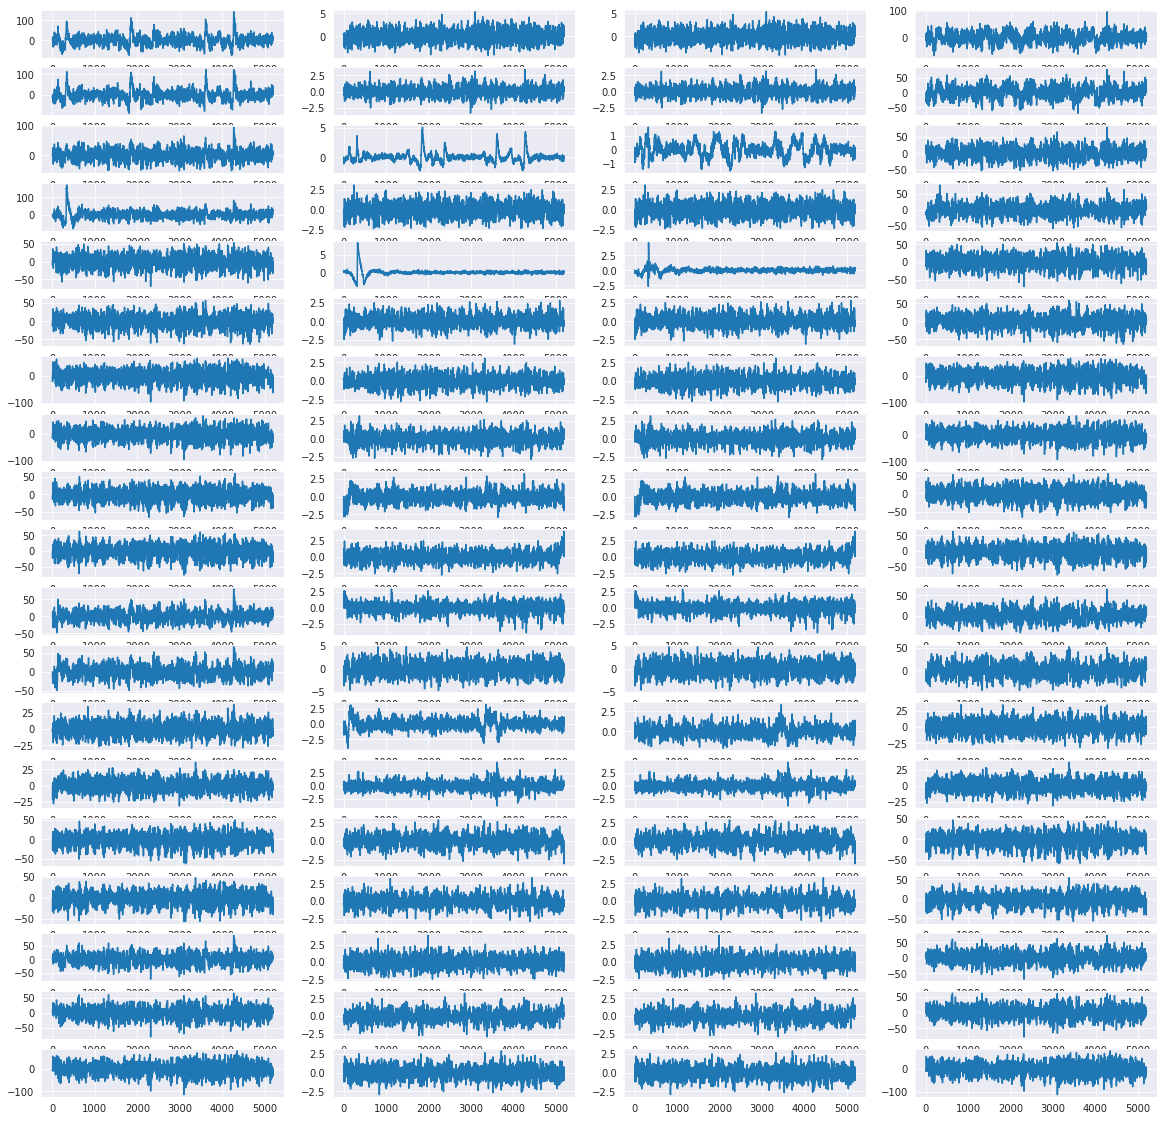

In [ ]:
fig, axs = plt.subplots(nrows=int(np_cont_ICs.shape[1]),
                        ncols=4, figsize=(20,20))

for idx_e_subj, e_subj in enumerate(np_cont_ICs):
    for idx_e_ch, e_ch in enumerate(e_subj):
        axs[idx_e_ch,0].plot(np_raws[idx_e_subj, idx_e_ch, :])
        axs[idx_e_ch,1].plot(np_cont_ICs[idx_e_subj, idx_e_ch, :])
        axs[idx_e_ch,2].plot(denoised_ICs_subjects[idx_e_subj, idx_e_ch, :])
        axs[idx_e_ch,3].plot(np_denoised_EEG_subjects[idx_e_subj, idx_e_ch, :])
        # break
    break

# Performance metrics

In [ ]:
# Prepare data for calculating metrics
reconstructed_pure_EEG = np.array(grab_children(selectedLength_pureEEG))
reconstructed_cont_EEG = np.array(grab_children(selectedLength_contEEG))
reconstructed_denoised_EEG = np_denoised_EEG_subjects
print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
print(list_denoised_EEG_keys)

# Get some samples
print(reconstructed_pure_EEG[0,0,:10])
print(reconstructed_cont_EEG[0,0,:10])
print(reconstructed_denoised_EEG[0,0,:10])

(54, 19, 5200)
['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con']
[11.333812  12.3151865 10.298577  17.469858  23.68372   26.498333
 23.249773  18.782053  15.634403  13.411441 ]
[11.31871986 12.29839897 10.28273773 17.45271301 23.6586895  26.45616531
 23.17921638 18.67058563 15.468853   13.17694283]
[-0.62914228  0.51630169 -1.33498801  5.99797876 12.3651

In [ ]:
# Save Numpy to Files
"""
5 EOG artifact removal techniques
- 'WT'
- 'ICA'
- 'wICA'
- 'WNN'
- 'SRGAN'
"""
ar_techniques = 'wICA'

np.save(
    file=f'Result/before_after_removal/{ar_techniques}_pure_EEG',
    arr=reconstructed_pure_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_cont_EEG',
    arr=reconstructed_cont_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_denoised_EEG',
    arr=reconstructed_denoised_EEG,
    allow_pickle=True, fix_imports=True)

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

def calculate_SAR(cont_EEG_e_CH,denoised_EEG_e_CH):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG_e_CH) / np.std(cont_EEG_e_CH-denoised_EEG_e_CH))
    return SAR

def calculate_MSC(cont_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    MSC = scipy.signal.coherence(x=cont_EEG_e_CH, y=denoised_EEG_e_CH,
                                 fs=200, window='hann', nperseg=200,
                                 noverlap=None, nfft=None, detrend=False,
                                 axis=-1)
    return MSC

def calculate_PSD(EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    PSD = scipy.signal.welch(x=EEG_e_CH,
                             fs=200, window='hann', nperseg=200, 
                             noverlap=None, nfft=None, detrend=False,
                             scaling='density',
                             axis=-1)
    return PSD

In [ ]:
pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                      index= EEG_electrodes,
                      columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
df_RMSE

Avg. RMSE of each Electrodes: 
Fp1    196.010226
Fp2    250.130714
F3      54.102282
F4      63.097302
C3      26.809605
C4      42.637983
P3      26.212760
P4      41.092346
O1      18.870727
O2      42.294893
F7      61.051516
F8     113.071960
T3      18.796911
T4      40.123709
T5      19.174282
T6      26.965025
Fz     121.689500
Cz      32.412416
Pz      30.800722
dtype: float64
Grand Avg. RMSE: 64.49183576013225


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,sim11_con,sim12_con,sim13_con,sim14_con,sim15_con,sim16_con,sim17_con,sim18_con,sim19_con,sim20_con,sim21_con,sim22_con,sim23_con,sim24_con,sim25_con,sim26_con,sim27_con,sim28_con,sim29_con,sim30_con,sim31_con,sim32_con,sim33_con,sim34_con,sim35_con,sim36_con,sim37_con,sim38_con,sim39_con,sim40_con,sim41_con,sim42_con,sim43_con,sim44_con,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,112.951633,102.296366,127.394076,144.119701,403.804447,157.674725,104.855584,258.099444,111.723974,96.759901,111.182395,153.539405,167.138018,85.806454,147.195461,241.127433,312.778818,169.226365,101.719605,97.080673,432.671808,244.843065,684.409205,52.849706,149.682137,169.054612,204.780202,145.554733,409.207884,388.835567,289.595512,203.175612,269.458942,213.139063,285.902093,142.716212,205.136808,106.086010,221.404049,191.364023,227.593645,126.137655,88.736806,78.141613,71.740486,333.175149,260.951032,164.575815,93.252398,228.983384,281.596872,216.563757,69.248724,127.513159
Fp2,128.235879,85.804085,115.544778,131.304183,297.046897,159.132354,104.332367,279.015887,101.801354,100.709321,165.239928,136.068430,111.154603,86.070790,135.974479,215.357716,244.621075,176.216427,100.133006,115.311772,441.339200,209.318880,906.705908,210.160823,427.776386,165.304407,174.908316,127.635774,329.776795,454.509360,287.695442,211.747873,273.495332,204.692385,468.224285,115.766336,195.188032,97.482125,229.949920,200.946561,213.367980,152.687789,87.095327,78.693868,111.637633,371.800791,2453.215719,181.772222,89.677652,248.631637,268.154402,238.428275,91.585854,198.609914
F3,17.871067,36.762701,32.845916,39.146534,73.934673,23.529944,18.900913,35.752420,16.551667,12.710247,21.908368,26.658596,42.554051,17.045018,32.941251,76.963596,437.790955,33.310680,15.395017,24.667417,81.709443,56.517198,154.949248,10.636025,25.799083,31.486110,42.883305,51.633969,488.584098,46.025873,71.851835,42.712683,54.247600,37.691466,58.186088,72.653153,45.421531,17.875172,42.618967,49.260305,56.556743,26.675293,21.485884,15.463516,16.579380,42.855265,35.724459,24.644584,12.254982,29.002552,42.499903,37.372669,20.784482,19.639321
F4,318.891349,28.101856,28.550378,54.238173,68.921569,32.262131,17.836043,53.382034,16.815475,22.227314,58.508712,28.450683,19.915455,15.663045,31.583786,36.038672,378.557808,53.204898,35.977040,31.663016,96.516537,46.749959,257.660511,173.330587,24.857898,27.024444,49.572003,56.250756,83.255394,80.082425,61.020197,64.479641,53.799147,33.860113,168.506733,32.311531,45.002353,14.100863,46.185477,56.491888,42.982452,60.380998,38.038112,17.980103,38.576959,58.945284,38.332598,41.769730,17.538096,59.952304,39.497767,34.153040,41.263688,75.995291
C3,25.364292,24.461512,17.524610,25.393398,19.062837,12.969313,12.142364,10.973940,5.734033,4.994318,6.824696,8.733896,26.908685,7.993230,16.201917,43.915758,563.486697,12.555310,5.664830,19.090290,25.057782,23.695467,53.353042,5.675636,27.461266,7.856830,21.035115,25.299678,20.952078,11.881098,34.979228,13.825085,31.426694,17.132151,11.950005,48.842240,19.080388,11.400071,9.639677,17.866047,24.584858,14.564793,5.903251,9.858233,5.149142,8.548203,9.401004,6.209216,3.683125,8.618368,12.763359,12.893524,7.952193,9.183912
C4,10.485636,16.686387,13.024619,27.509487,15.974260,25.448345,12.411953,23.792445,8.917906,14.520616,45.539722,8.992507,5.643995,7.019915,12.374136,20.171861,986.955800,32.234653,15.100967,15.911150,32.436155,17.084650,53.786819,152.852427,9.868553,8.558289,32.293636,42.463751,32.840307,16.236726,25.235564,18.487469,54.414270,24.259333,93.102066,11.795729,15.229425,6.397891,14.558545,26.048505,16.000289,51.973863,11.458209,13.710474,8.802776,13.814050,10.754050,15.285165,11.524593,24.633450,9.236526,8.355545,36.703951,63.531677
P3,28.676044,17.741564,9.687311,22.618218,13.212251,13.946179,16.190278,9.973134,6.245132,4.238254,2.532533,8.883752,29.000881,9.6071

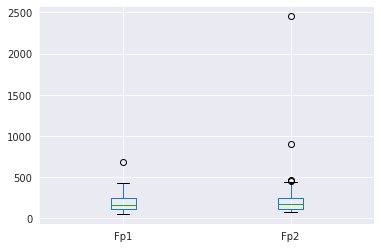

In [ ]:
df_RMSE.copy().transpose().boxplot(['Fp1', 'Fp2'])

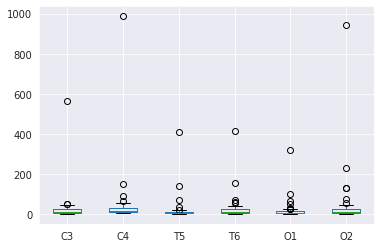

In [ ]:
df_RMSE.copy().transpose().boxplot(['C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

In [ ]:
cont_denoised_SAR_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_SAR.append(oneCH_SAR)

    cont_denoised_SAR_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=cont_denoised_SAR_subjs, 
                      index= EEG_electrodes,
                      columns=cont_denoised_SAR_subjs.keys())

print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
df_SAR

Avg. SAR of each Electrodes: 
Fp1     1.308827
Fp2     1.261961
F3      3.704657
F4      3.434441
C3      7.252942
C4      6.721532
P3     10.092223
P4      9.476362
O1     11.044966
O2     10.249920
F7      2.437452
F8      2.262904
T3      4.964666
T4      4.671538
T5      8.755867
T6      8.371054
Fz      3.319699
Cz      7.138532
Pz     10.474670
dtype: float64
Grand Avg. SAR: 6.154958581892333


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,sim11_con,sim12_con,sim13_con,sim14_con,sim15_con,sim16_con,sim17_con,sim18_con,sim19_con,sim20_con,sim21_con,sim22_con,sim23_con,sim24_con,sim25_con,sim26_con,sim27_con,sim28_con,sim29_con,sim30_con,sim31_con,sim32_con,sim33_con,sim34_con,sim35_con,sim36_con,sim37_con,sim38_con,sim39_con,sim40_con,sim41_con,sim42_con,sim43_con,sim44_con,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,2.685771,2.127783,1.763771,2.719653,1.762930,1.075016,2.128885,1.819615,0.791083,1.573583,1.274133,0.327271,0.853241,1.316109,2.225125,1.021417,1.435877,0.666913,1.653733,0.923283,1.933861,1.784066,0.408418,0.706661,1.869727,1.166255,2.129544,2.583143,1.936238,1.042455,1.797015,2.316599,1.301263,1.665279,0.515591,1.080757,1.210588,0.743221,0.377494,0.743658,1.066567,2.919969,0.834845,1.540984,0.236954,0.354937,1.324626,0.203875,0.932007,-0.089189,0.711736,1.001178,0.860849,1.320298
Fp2,2.660369,2.318870,1.616014,2.162595,1.775454,0.657429,1.654767,1.756636,0.763755,1.535076,1.260374,0.374123,0.985762,1.357514,2.340275,1.040126,1.861163,0.769856,1.773786,1.173939,1.930054,1.792376,0.245549,0.647553,2.443053,1.129737,1.647654,2.181950,2.074459,1.250691,1.745863,2.084551,0.960641,1.497186,0.534476,0.830883,1.139829,0.717850,0.388640,0.663706,0.740535,2.028764,0.843251,1.333121,0.535736,0.306171,0.939972,0.376462,0.919205,0.042968,0.638068,0.882027,1.068477,1.746556
F3,7.228165,6.632194,4.408965,6.534086,4.525271,4.512700,7.411053,4.915098,1.676424,2.762995,3.409981,1.970652,2.735819,4.051310,6.224892,4.321414,1.406878,3.228740,4.806071,4.804443,4.061942,5.052111,1.765083,4.138914,3.589975,2.704634,5.808443,6.159564,1.140139,3.461920,4.676178,7.014012,3.376471,4.710929,1.904418,2.312233,2.561690,2.000399,2.673865,3.369878,4.934722,8.030370,2.933593,4.732355,1.734555,1.071571,2.136435,1.214026,2.176129,0.912575,1.703963,1.949028,2.606263,3.865948
F4,3.044440,6.801915,4.287621,4.980838,4.068399,3.214801,6.351306,4.243076,1.556958,3.316732,3.766742,2.117068,2.809623,3.714533,6.029945,4.771456,2.861451,3.349334,5.174016,5.674708,3.933963,5.421732,0.779954,1.820208,3.574277,2.861054,5.685657,5.951616,3.249395,3.698745,4.399303,5.402553,2.955890,3.920060,2.207976,1.722493,2.700126,2.034493,2.515766,3.183398,3.961683,4.680100,2.247717,3.801819,1.896090,0.796018,2.302863,1.628902,1.998511,1.340754,1.270255,1.907103,2.786482,4.687889
C3,11.486110,12.354428,8.594735,10.949389,8.399543,7.291600,10.214792,8.515657,3.683351,4.919284,6.896127,4.639246,6.288669,8.446648,11.693674,8.513463,1.544910,7.450857,10.374531,10.499471,7.686852,8.644667,3.815581,8.760715,4.835070,6.458181,9.404539,8.983935,5.744020,7.175873,7.847978,11.699577,6.135694,10.171549,3.685819,2.886410,5.402947,5.643455,7.669124,7.853245,8.680258,12.293823,6.943840,8.738243,5.303605,4.924280,4.394257,4.048193,5.236522,3.303927,5.325336,4.909498,6.266148,8.029203
C4,13.563998,12.423945,8.478963,8.945228,5.515442,3.239501,10.846353,6.497408,3.443912,5.748154,5.385992,5.531896,6.338268,7.122187,11.664553,10.093926,2.546433,5.698765,12.370888,13.268719,7.268985,9.253127,3.219678,1.946045,6.467143,6.010600,9.484253,7.815988,5.356681,5.940337,7.756936,9.906027,5.754263,7.473252,3.667791,3.198466,5.875682,6.382170,7.944972,7.062377,7.170739,6.407902,5.384673,7.529797,5.856090,4.492797,5.086407,4.607330,4.824534,3.414929,5.237885,4.626121,5.184504,6.629724
P3,14.955365,18.304575,13.578357,13.188765,9.545544,7.871701,10.013598,10.226651,4.831456,7.032829,9.590458,5.473708,9.569795,11.182119,13.429765,10.545681,1.769145,12.266324,12.510531,10.778419,13.782409,13.513771,3.653405,11.619663,9.354143,11.568106,13.104836,11.181843,7.439673,10.540482,13.709682,11.340524,7.875044,12.260818,6.329565,2.656488,9.230173,7.009176,13.469242,13.254674,10.318932,11.926335,10.624793,9.732889,12.321363,11.961059,8.617566,8.933579,8.443279,6.167156,7.959632,9.596947,8.803247,10.01

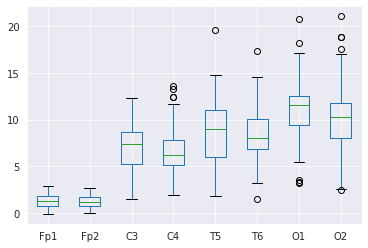

In [ ]:
df_SAR.copy().transpose().boxplot(['Fp1','Fp2','C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

The shape of cont_denoised_MSC_subjs: (54, 19, 2, 101)


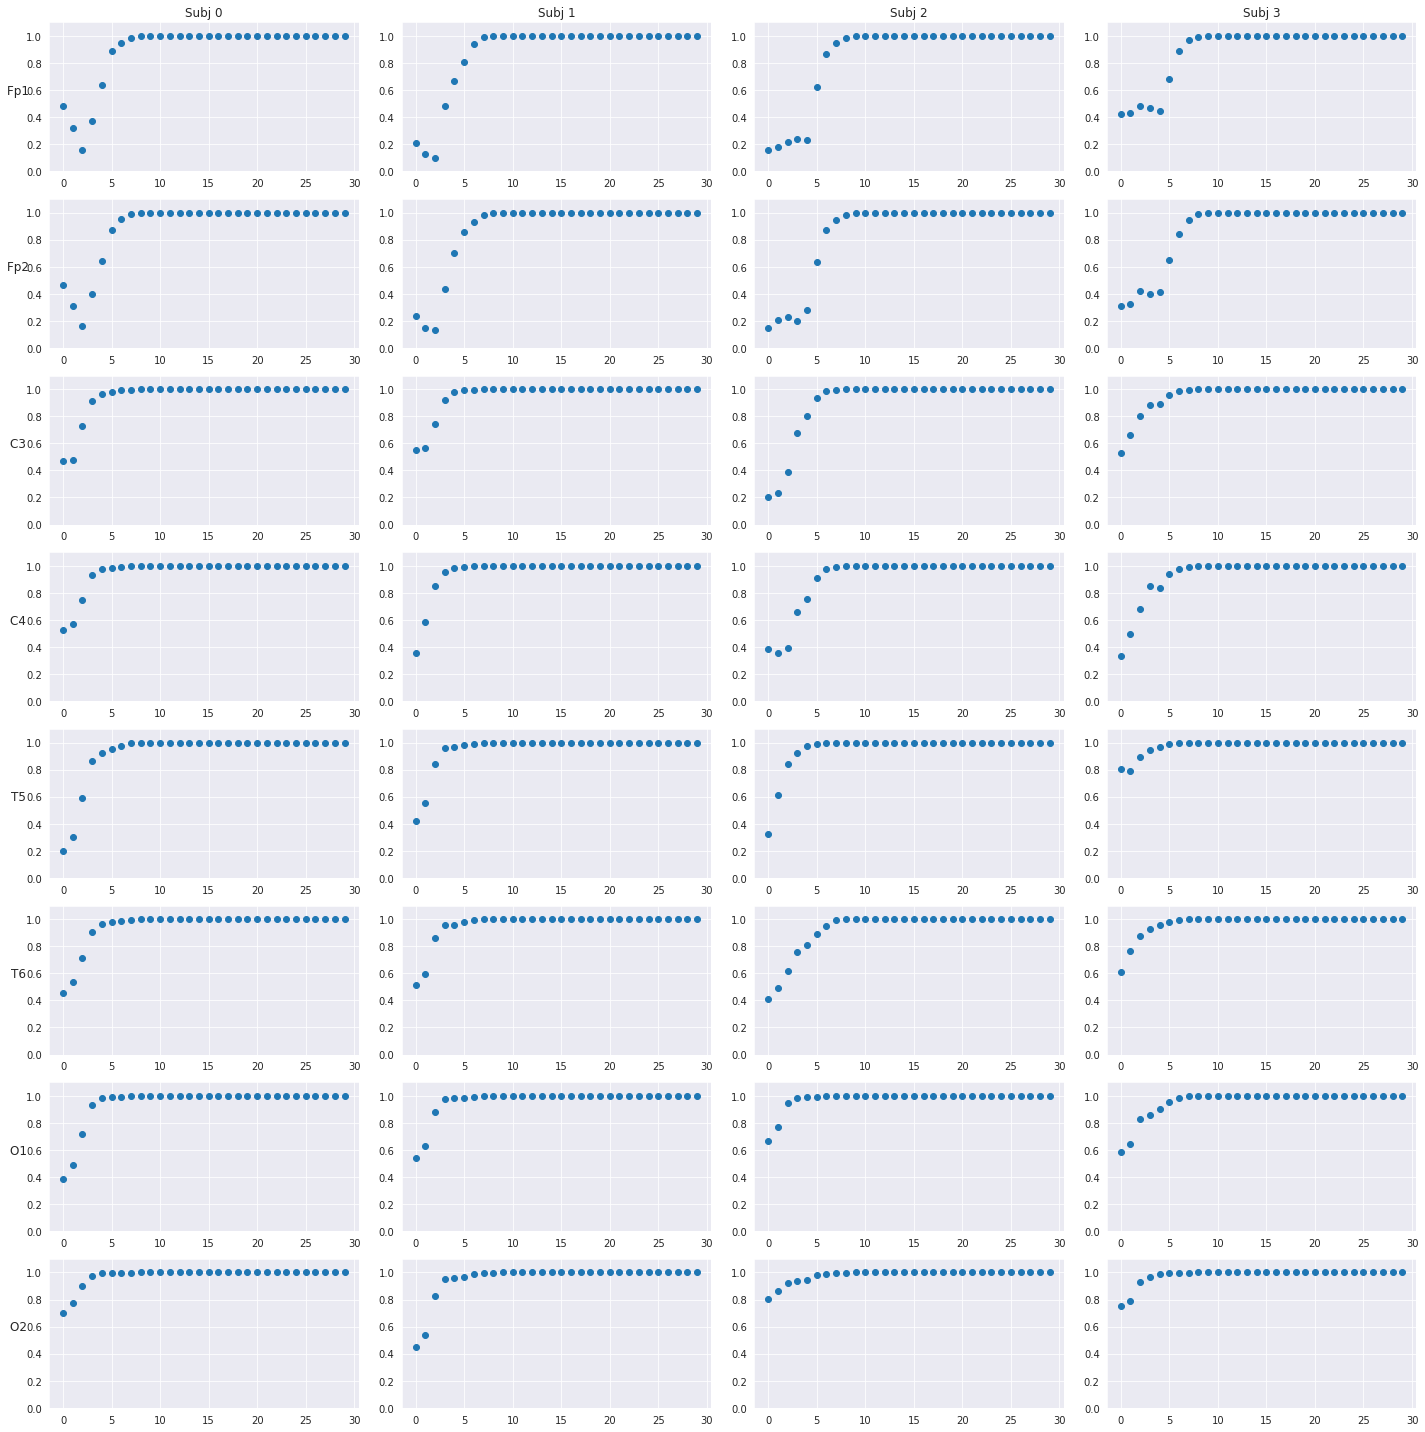

In [ ]:
cont_denoised_MSC_subjs = []

for idx_e_subject in range(number_subjects):
    manyCH_MSC = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_MSC = calculate_MSC(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_MSC.append(oneCH_MSC)

    cont_denoised_MSC_subjs.append(manyCH_MSC)

cont_denoised_MSC_subjs = np.array(cont_denoised_MSC_subjs)
print(f'The shape of cont_denoised_MSC_subjs: {cont_denoised_MSC_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']


# Plot MSC
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].scatter(
        cont_denoised_MSC_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[0,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,0].set_ylim(0,1.1)

    axs[idx_e_ch,1].scatter(
        cont_denoised_MSC_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].set_ylim(0,1.1)

    axs[idx_e_ch,2].scatter(
        cont_denoised_MSC_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].set_ylim(0,1.1)

    axs[idx_e_ch,3].scatter(
        cont_denoised_MSC_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].set_ylim(0,1.1)

fig.tight_layout()
plt.show()

The shape of pure_PSD_subjs: (54, 19, 2, 101)
The shape of cont_PSD_subjs: (54, 19, 2, 101)
The shape of denoised_PSD_subjs: (54, 19, 2, 101)


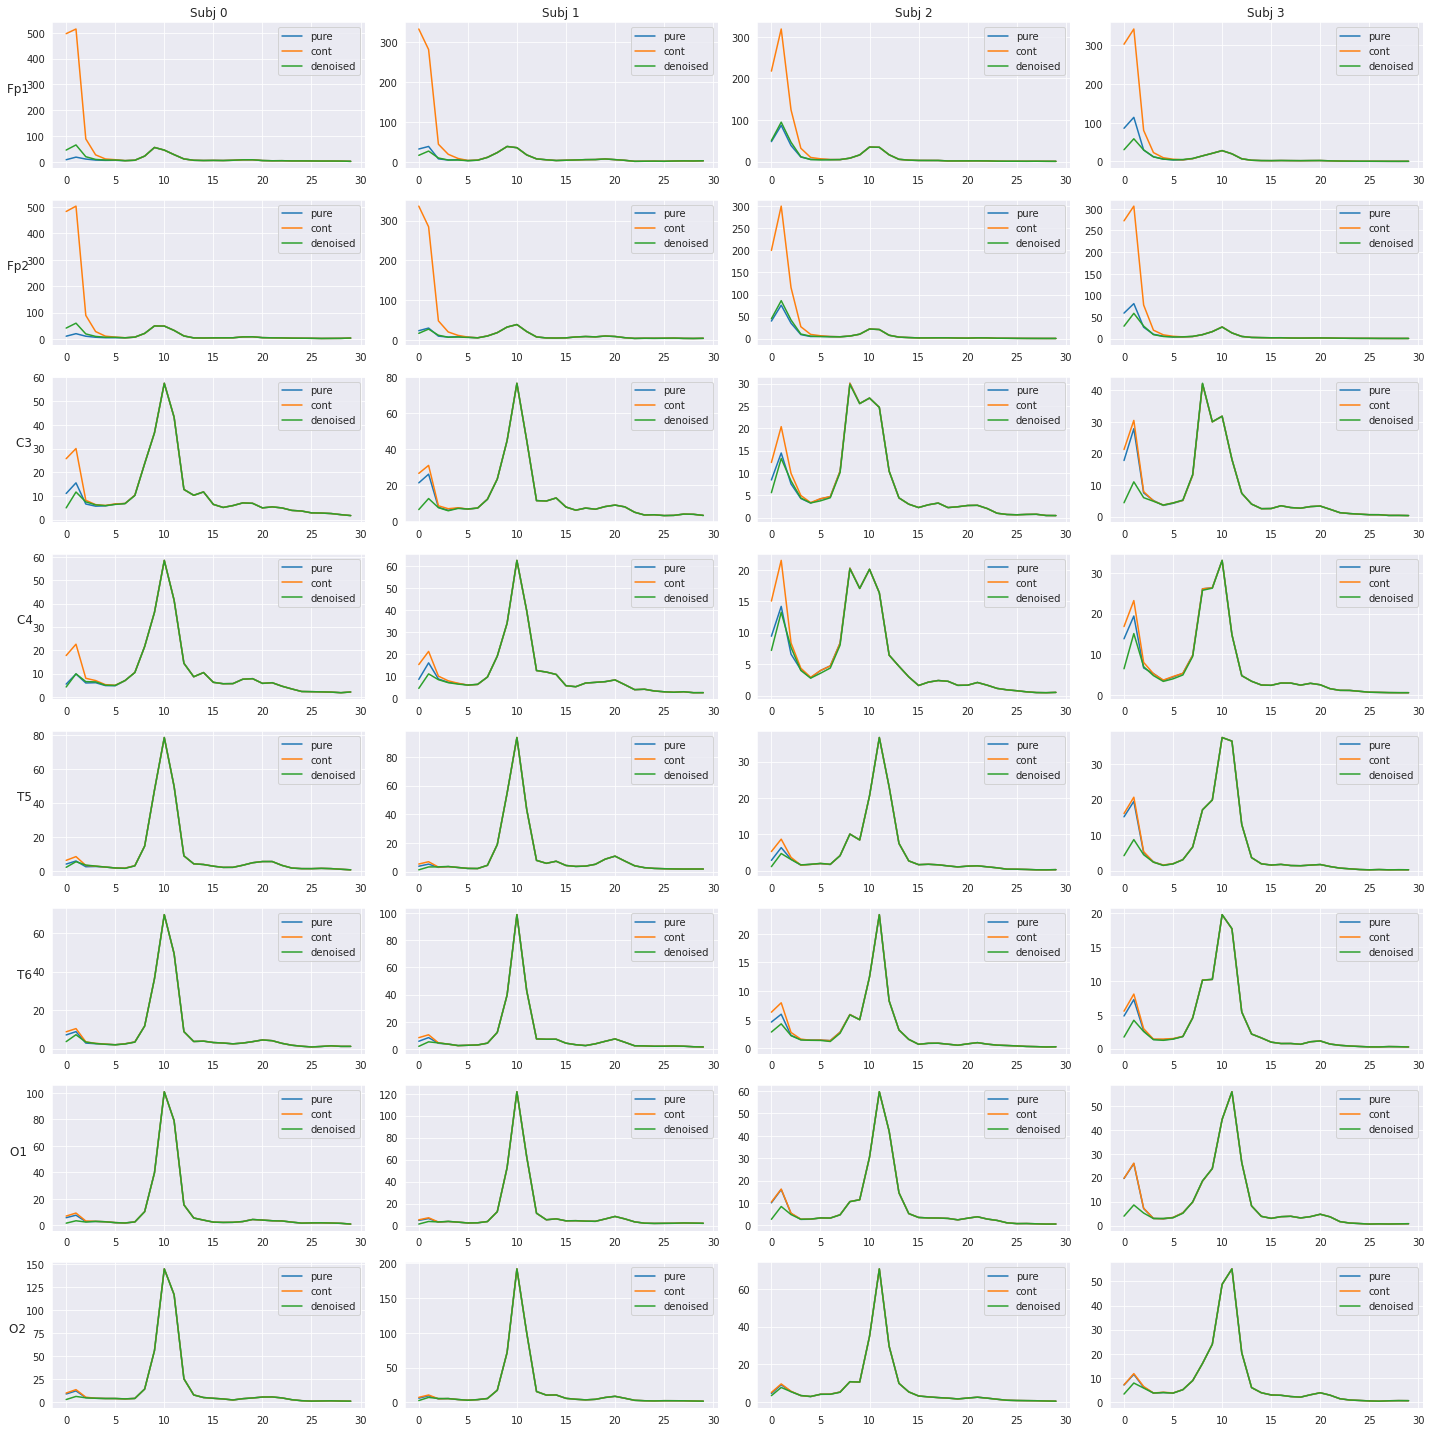

In [ ]:
pure_PSD_subjs = []
cont_PSD_subjs = []
denoised_PSD_subjs = []

for idx_e_subject in range(number_subjects):
    pure_PSD_CHs = []
    cont_PSD_CHs = []
    denoised_PSD_CHs = []

    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_pure_PSD = calculate_PSD(manyCH_pureEEG[idx_channel])
        oneCH_cont_PSD = calculate_PSD(manyCH_contEEG[idx_channel])
        oneCH_denoised_PSD = calculate_PSD(manyCH_denoisedEEG[idx_channel])

        pure_PSD_CHs.append(oneCH_pure_PSD)
        cont_PSD_CHs.append(oneCH_cont_PSD)
        denoised_PSD_CHs.append(oneCH_denoised_PSD)

    pure_PSD_subjs.append(pure_PSD_CHs)
    cont_PSD_subjs.append(cont_PSD_CHs)
    denoised_PSD_subjs.append(denoised_PSD_CHs)

pure_PSD_subjs = np.array(pure_PSD_subjs)
cont_PSD_subjs = np.array(cont_PSD_subjs)
denoised_PSD_subjs = np.array(denoised_PSD_subjs)

print(f'The shape of pure_PSD_subjs: {pure_PSD_subjs.shape}')
print(f'The shape of cont_PSD_subjs: {cont_PSD_subjs.shape}')
print(f'The shape of denoised_PSD_subjs: {denoised_PSD_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']

# Plot PSD
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].plot(
        pure_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        cont_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        denoised_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,1].plot(
        pure_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].plot(
        cont_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].plot(
        denoised_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,2].plot(
        pure_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].plot(
        cont_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].plot(
        denoised_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,3].plot(
        pure_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].plot(
        cont_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].plot(
        denoised_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].legend(['pure', 'cont', 'denoised'])

fig.tight_layout()
plt.show()

# Save metrics

In [ ]:
!pwd
df_RMSE.to_csv(path_or_buf='save_results/03_wICA_RMSE.csv', 
               sep=',', float_format=None)
df_SAR.to_csv(path_or_buf='save_results/03_wICA_SAR.csv', 
               sep=',', float_format=None)


/content/drive/My Drive/Colab Notebooks/Thesis_st121166
